In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_datasets as tfds
import pathlib
import os
from sklearn.model_selection import train_test_split

# 1- Input pipeline

In [2]:
data_path = pathlib.Path(r"../Downloads/archive/Fish_Dataset/Fish_Dataset")

In [3]:
#list of pathes for all images 
all_images = list(data_path.glob(r'*/*/*.jpg')) + list(data_path.glob(r'*/*/*.png'))

images = []
labels = []

#looping through the pathes to extract pathes and labels
for item in all_images:
    
    path = os.path.normpath(item)
    splits = path.split(os.sep)
    
    if 'GT' not in splits[-2]:
    
        images.append(item)
    
        label = splits[-2]
        labels.append(label)

In [4]:
# Dataframe with two columns: image_path, label 
image_pathes = pd.Series(images).astype(str)
labels = pd.Series(labels)

dataframe = pd.concat([image_pathes, labels], axis=1)

dataframe.columns = ['images', 'labels']

dataframe.head()

,images,labels
0,../Downloads/archive/Fish_Dataset/Fish_Dataset...,Sea Bass
1,../Downloads/archive/Fish_Dataset/Fish_Dataset...,Sea Bass
2,../Downloads/archive/Fish_Dataset/Fish_Dataset...,Sea Bass
3,../Downloads/archive/Fish_Dataset/Fish_Dataset...,Sea Bass
4,../Downloads/archive/Fish_Dataset/Fish_Dataset...,Sea Bass


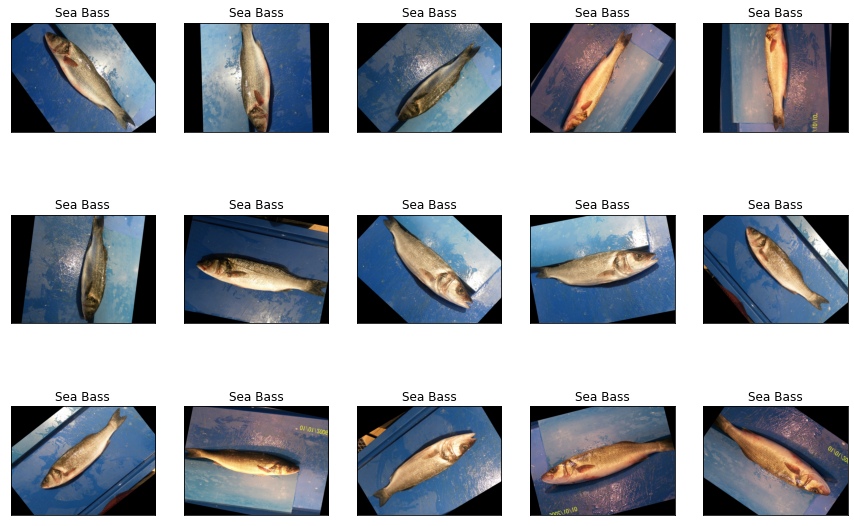

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataframe.images[i]))
    ax.set_title(dataframe.labels[i])
    
plt.show()

In [6]:
#Shuffle the dataframe rows and split it to train, val, test splits

In [7]:
shuffled_dataframe = dataframe.sample(frac = 1)

In [8]:
all_train, test = train_test_split(shuffled_dataframe, test_size=0.15, random_state=0)
train, val = train_test_split(all_train, test_size=0.17, random_state=0)

In [9]:
training_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                                   rotation_range=40,
                                                                   zoom_range=0.2,
                                                                   width_shift_range=0.2,
                                                                   height_shift_range=0.2,
                                                                   shear_range=0.2,
                                                                   horizontal_flip=True,
                                                                   vertical_flip=True)

training_generator = training_data_gen.flow_from_dataframe(dataframe=train,
                                                           x_col='images', y_col='labels',
                                                           target_size=(224, 224),
                                                           color_mode='rgb',
                                                           class_mode='categorical',
                                                           batch_size=64)
#------------------------------------------------------------------------------------------------------
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
validation_generator = val_data_gen.flow_from_dataframe(dataframe=val,
                                                        x_col='images', y_col='labels',
                                                        target_size=(224, 224),
                                                        color_mode='rgb',
                                                        class_mode='categorical',
                                                        batch_size=64)
#------------------------------------------------------------------------------------------------------
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_generator = test_data_gen.flow_from_dataframe(dataframe=test,
                                                   x_col='images', y_col='labels',
                                                   target_size=(224, 224),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                  batch_size=64)

Found 6349 validated image filenames belonging to 9 classes.
Found 1301 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


# 2- Image classification using Multi Layer Perceptron (MLP) (Normal Neural Network without any convolutions)

In [10]:
mlp_model = tf.keras.models.Sequential()

#Flatten layer
mlp_model.add(tf.keras.layers.Flatten(input_shape=(224, 224, 3)))

# 3 Hidden Layers with (256, 256, 128) neurons and relu activation function
mlp_model.add(tf.keras.layers.Dense(256, activation='relu'))
# dropout layer to reduce the overfitting 
mlp_model.add(tf.keras.layers.Dropout(0.4))
mlp_model.add(tf.keras.layers.Dense(256, activation='relu'))
mlp_model.add(tf.keras.layers.Dense(128, activation='relu'))

# output layer with 9 neurons and softmax activation function
mlp_model.add(tf.keras.layers.Dense(9, activation = 'softmax'))

2021-10-04 10:19:45.314562: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-04 10:19:45.314922: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


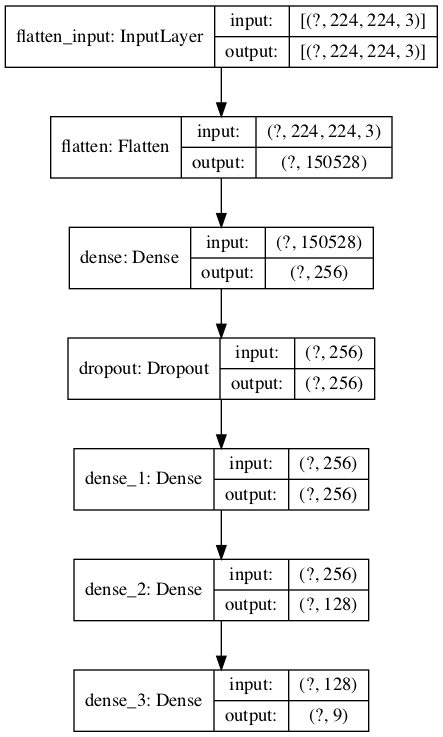

In [11]:
# we can se the network using: 

tf.keras.utils.plot_model(mlp_model,
                          show_shapes=True,
                          show_layer_names=True)

In [12]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1161      
Total params: 38,635,273
Trainable params: 38,635,273
Non-trainable params: 0
____________________________________________

In [13]:
mlp_model.compile(loss='categorical_crossentropy',
                 optimizer='rmsprop',
                 metrics=['acc'])

In [14]:
mlp_model.fit(training_generator, 
             steps_per_epoch=24, 
             validation_data=validation_generator,
             validation_steps=20,
             epochs=5)

2021-10-04 10:20:02.484084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 7 of 100
2021-10-04 10:20:11.633467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 13 of 100
2021-10-04 10:20:21.567076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 20 of 100
2021-10-04 10:20:32.381578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 26 of 100
2021-10-04 10:20:41.778758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:20:52.609407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 10:21:01.861969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

Train for 24 steps, validate for 20 steps
Epoch 1/5


2021-10-04 10:22:29.562073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:22:39.943397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:22:49.063022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:22:59.578277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:23:10.079143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 100
2021-10-04 10:23:19.260305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 10:23:29.824088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

24/24 [==============================] - 168s 7s/step - loss: 34.3283 - acc: 0.1120 - val_loss: 2.1958 - val_acc: 0.1016
Epoch 2/5


2021-10-04 10:25:15.690216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:25:26.141503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:25:35.252979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:25:45.623809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:25:56.049161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 100
2021-10-04 10:26:05.204117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 10:26:15.833902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

24/24 [==============================] - 162s 7s/step - loss: 2.9496 - acc: 0.1159 - val_loss: 2.1968 - val_acc: 0.0992
Epoch 3/5


2021-10-04 10:27:57.359100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:28:07.737717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:28:18.168337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 24 of 100
2021-10-04 10:28:27.182060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:28:37.747209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 100
2021-10-04 10:28:46.891557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 10:28:57.350797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

24/24 [==============================] - 163s 7s/step - loss: 2.2317 - acc: 0.1120 - val_loss: 2.1964 - val_acc: 0.1258
Epoch 4/5


2021-10-04 10:30:40.735191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:30:51.109669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:31:00.337866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:31:10.654423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:31:21.110020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 100
2021-10-04 10:31:31.595054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 47 of 100
2021-10-04 10:31:41.435264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

24/24 [==============================] - 165s 7s/step - loss: 2.2310 - acc: 0.1061 - val_loss: 2.1973 - val_acc: 0.1234
Epoch 5/5


2021-10-04 10:33:25.943777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:33:36.555179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:33:45.830822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:33:56.383216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:34:05.606423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 10:34:16.160222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 10:34:25.756870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

24/24 [==============================] - 163s 7s/step - loss: 2.1975 - acc: 0.1145 - val_loss: 2.5700 - val_acc: 0.1148


**Next we will use Convolutional neural networks to train the classifier**

# 3- Image classification using Convolutional Neural Networks (CNN)

In [15]:
from IPython.display import Image
Image(url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwed5zvnSDt0zrFd_gf-kUIMoF7Nm6FXIwDw&usqp=CAU',
      width=750,
      height=500)

In [16]:
Image(url='https://www.researchgate.net/profile/Lavender-Jiang-2/publication/343441194/figure/fig2/AS:921001202311168@1596595206463/Basic-CNN-architecture-and-kernel-A-typical-CNN-consists-of-several-component-types.ppm',
      width=750,
      height=500)

In [17]:
Image(url='https://i.stack.imgur.com/CQtHP.gif',
      width=750,
      height=500)

In [18]:
Image(url='https://miro.medium.com/max/658/0*jLoqqFsO-52KHTn9.gif',
      width=750,
      height=500)


In [19]:
Image(url='https://res.cloudinary.com/practicaldev/image/fetch/s--nUoflRuG--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://i.ibb.co/kG5vPdn/final-cnn.png',
      width=750,
      height=500)

In [20]:
Image(url='https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif',
      width=750,
      height=500)

## Image classification using CNN

In [21]:
# Building the model 
cnn_model = tf.keras.models.Sequential()

#----------------------------------------------------------------------------------------------

#Conv layer: 32 filters of size (3, 3), with strides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, 
                                     activation='relu', input_shape=(224,224,3)))
#max-poolig layer with pool_size of (2,2)
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

#Conv layer: 64 filters of size (3, 3), withstrides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
#max-poolig layer with pool_size of (2,2)
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

#Conv layer: 128 filters of size (3, 3), withstrides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
#max-poolig layer with pool_size of (2,2)
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

#Conv layer: 128 filters of size (3, 3), withstrides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
#max-poolig layer with pool_size of (2,2)
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

#Conv layer: 128 filters of size (3, 3), withstrides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
#max-poolig layer with pool_size of (2,2)
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------
#Flattening the output of the last pooling layer 
cnn_model.add(tf.keras.layers.Flatten())

#cnn_model.add(tf.keras.layers.GlobalAveragePooling2D())


#Fully connected layer with 256 units and relu activation
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))

#Dropout layer to lower the overfitting with dropout rate of rate 0.4
cnn_model.add(tf.keras.layers.Dropout(0.4))

#Fully connected layer with 9 units and softmax activation
cnn_model.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [22]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)      

As we can see the number of parameters is reduced from 38,635,273 in the MLP to 2,066,313 in CNN. reducing the parameters to 5.2% of the number of parameters in the MLP !!!

In [23]:
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer='rmsprop',
                 metrics=['acc'])

In [24]:
history = cnn_model.fit(training_generator, 
                         steps_per_epoch=99, 
                         validation_data=validation_generator,
                         validation_steps=20,
                         epochs=24)

2021-10-04 10:36:10.624794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:36:21.398214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:36:30.568573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:36:41.078486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:36:50.363851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 10:37:01.062690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 10:37:10.621543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

Train for 99 steps, validate for 20 steps
Epoch 1/24


2021-10-04 10:38:27.229671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:38:37.154699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 15 of 100
2021-10-04 10:38:47.645972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:38:57.099624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 30 of 100
2021-10-04 10:39:07.706616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 10:39:17.017878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 45 of 100
2021-10-04 10:39:27.624133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 495s 5s/step - loss: 2.2771 - acc: 0.1317 - val_loss: 2.0030 - val_acc: 0.2203
Epoch 2/24


2021-10-04 10:46:39.879390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:46:50.436923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:46:59.665759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:47:10.210845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:47:19.665243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 10:47:30.271010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 10:47:39.772975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 490s 5s/step - loss: 2.0496 - acc: 0.2110 - val_loss: 1.7538 - val_acc: 0.3398
Epoch 3/24


2021-10-04 10:54:50.061366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 10:55:00.572775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 10:55:09.931122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 10:55:20.469104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 10:55:29.850066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 10:55:40.494959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 10:55:49.967475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 480s 5s/step - loss: 1.8351 - acc: 0.3095 - val_loss: 1.6887 - val_acc: 0.3641
Epoch 4/24


2021-10-04 11:02:50.482104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 11:03:00.997632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 11:03:10.582115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 11:03:21.138387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 11:03:30.603361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 11:03:39.906281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 45 of 100
2021-10-04 11:03:50.568708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 477s 5s/step - loss: 1.5737 - acc: 0.4158 - val_loss: 0.9589 - val_acc: 0.6844
Epoch 5/24


2021-10-04 11:10:47.146617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 11:10:57.633250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 11:11:06.907735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 11:11:17.368185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 11:11:26.896313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 11:11:37.497377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 11:11:46.822463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 478s 5s/step - loss: 1.2904 - acc: 0.5327 - val_loss: 1.0508 - val_acc: 0.5930
Epoch 6/24


2021-10-04 11:18:44.510763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 11:18:54.981685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 11:19:04.173879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 11:19:14.647066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 11:19:24.021183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 11:19:34.785169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 11:19:44.076946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 476s 5s/step - loss: 1.0645 - acc: 0.6115 - val_loss: 0.5200 - val_acc: 0.8289
Epoch 7/24


2021-10-04 11:26:39.934126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 11:26:50.482413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 11:26:59.645622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 11:27:10.126326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 11:27:20.698972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 100
2021-10-04 11:27:30.144356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 11:27:40.677971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 484s 5s/step - loss: 0.9134 - acc: 0.6730 - val_loss: 0.7830 - val_acc: 0.7258
Epoch 8/24


2021-10-04 11:34:43.670732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 11:34:54.098539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 11:35:03.319833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 11:35:13.782997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 11:35:23.429076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 11:35:34.022343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 100
2021-10-04 11:35:43.279652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 492s 5s/step - loss: 0.8131 - acc: 0.7173 - val_loss: 0.6976 - val_acc: 0.7281
Epoch 9/24


2021-10-04 11:42:55.714473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 11:43:06.234545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 11:43:15.866030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 23 of 100
2021-10-04 11:43:25.284133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 30 of 100
2021-10-04 11:43:35.660527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 37 of 100
2021-10-04 11:43:45.365151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 44 of 100
2021-10-04 11:43:56.103440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 547s 6s/step - loss: 0.6857 - acc: 0.7656 - val_loss: 0.2986 - val_acc: 0.8984
Epoch 10/24


2021-10-04 11:52:03.153338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 6 of 100
2021-10-04 11:52:12.767449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 12 of 100
2021-10-04 11:52:23.123898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 19 of 100
2021-10-04 11:52:33.878889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 26 of 100
2021-10-04 11:52:44.138377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 33 of 100
2021-10-04 11:52:53.277996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 100
2021-10-04 11:53:02.791120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 583s 6s/step - loss: 0.6125 - acc: 0.7905 - val_loss: 0.2884 - val_acc: 0.9047
Epoch 11/24


2021-10-04 12:01:47.100052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 12:01:56.938070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 15 of 100
2021-10-04 12:02:05.966226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 22 of 100
2021-10-04 12:02:16.568407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 30 of 100
2021-10-04 12:02:27.163513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 12:02:36.180056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 45 of 100
2021-10-04 12:02:46.621240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 532s 5s/step - loss: 0.5710 - acc: 0.8186 - val_loss: 0.4681 - val_acc: 0.8328
Epoch 12/24


2021-10-04 12:10:39.118800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 7 of 100
2021-10-04 12:10:48.818134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 13 of 100
2021-10-04 12:10:59.681166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 19 of 100
2021-10-04 12:11:09.395103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 25 of 100
2021-10-04 12:11:18.798945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 12:11:29.509995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 100
2021-10-04 12:11:39.305337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 525s 5s/step - loss: 0.6247 - acc: 0.8331 - val_loss: 0.2067 - val_acc: 0.9367
Epoch 13/24


2021-10-04 12:19:23.313372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 6 of 100
2021-10-04 12:19:33.823557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 13 of 100
2021-10-04 12:19:43.558166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 20 of 100
2021-10-04 12:19:53.306343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 27 of 100
2021-10-04 12:20:03.655484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 100
2021-10-04 12:20:14.254140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 41 of 100
2021-10-04 12:20:24.014519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 546s 6s/step - loss: 0.4037 - acc: 0.8624 - val_loss: 0.2918 - val_acc: 0.8844
Epoch 14/24


2021-10-04 12:28:29.637670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 7 of 100
2021-10-04 12:28:39.915962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 14 of 100
2021-10-04 12:28:49.145493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 20 of 100
2021-10-04 12:28:59.774267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 27 of 100
2021-10-04 12:29:09.323120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 33 of 100
2021-10-04 12:29:19.677141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 40 of 100
2021-10-04 12:29:30.258012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 561s 6s/step - loss: 0.4099 - acc: 0.8640 - val_loss: 0.1834 - val_acc: 0.9242
Epoch 15/24


2021-10-04 12:37:50.412029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 7 of 100
2021-10-04 12:38:00.692670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 14 of 100
2021-10-04 12:38:10.491838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 21 of 100
2021-10-04 12:38:20.197003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 27 of 100
2021-10-04 12:38:30.571242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 100
2021-10-04 12:38:39.912931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 40 of 100
2021-10-04 12:38:50.466912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 565s 6s/step - loss: 0.3546 - acc: 0.8827 - val_loss: 0.9161 - val_acc: 0.6797
Epoch 16/24


2021-10-04 12:47:15.745692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 6 of 100
2021-10-04 12:47:24.474001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 11 of 100
2021-10-04 12:47:34.606659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 18 of 100
2021-10-04 12:47:45.426481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 26 of 100
2021-10-04 12:47:55.036010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 100
2021-10-04 12:48:04.426434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 35 of 100
2021-10-04 12:48:14.663373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 567s 6s/step - loss: 0.3745 - acc: 0.8792 - val_loss: 0.2204 - val_acc: 0.9336
Epoch 17/24


2021-10-04 12:56:41.543303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 7 of 100
2021-10-04 12:56:52.761861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 14 of 100
2021-10-04 12:57:02.740130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 20 of 100
2021-10-04 12:57:11.841707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 27 of 100
2021-10-04 12:57:21.853921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 100
2021-10-04 12:57:32.196080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 41 of 100
2021-10-04 12:57:42.034079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 582s 6s/step - loss: 0.3170 - acc: 0.8993 - val_loss: 0.1398 - val_acc: 0.9531
Epoch 18/24


2021-10-04 13:06:22.971216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 6 of 100
2021-10-04 13:06:33.297033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 11 of 100
2021-10-04 13:06:43.246843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 100
2021-10-04 13:06:53.905881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 22 of 100
2021-10-04 13:07:03.733724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 27 of 100
2021-10-04 13:07:13.173194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 33 of 100
2021-10-04 13:07:24.111826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 547s 6s/step - loss: 0.3341 - acc: 0.8986 - val_loss: 0.0545 - val_acc: 0.9859
Epoch 19/24


2021-10-04 13:15:30.046069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 13:15:40.891117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 13:15:50.769894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 22 of 100
2021-10-04 13:16:01.066531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 28 of 100
2021-10-04 13:16:10.158982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 100
2021-10-04 13:16:19.656213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 40 of 100
2021-10-04 13:16:30.894572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 543s 5s/step - loss: 0.3088 - acc: 0.9090 - val_loss: 0.3830 - val_acc: 0.8633
Epoch 20/24


2021-10-04 13:24:33.862403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 13:24:43.173367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 14 of 100
2021-10-04 13:24:53.977554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 21 of 100
2021-10-04 13:25:04.198551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 28 of 100
2021-10-04 13:25:14.771436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 35 of 100
2021-10-04 13:25:23.731476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 41 of 100
2021-10-04 13:25:33.975746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 535s 5s/step - loss: 0.2554 - acc: 0.9241 - val_loss: 0.0214 - val_acc: 0.9961
Epoch 21/24


2021-10-04 13:33:28.224168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 13:33:38.420700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 13:33:48.892895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 24 of 100
2021-10-04 13:33:59.076351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 100
2021-10-04 13:34:08.077248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 100
2021-10-04 13:34:18.344812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 47 of 100
2021-10-04 13:34:28.549402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 456s 5s/step - loss: 0.3204 - acc: 0.9144 - val_loss: 0.0455 - val_acc: 0.9891
Epoch 22/24


2021-10-04 13:41:04.224201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 13:41:14.371599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 13:41:24.557401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 24 of 100
2021-10-04 13:41:34.697314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 100
2021-10-04 13:41:45.180351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 40 of 100
2021-10-04 13:41:54.100752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 47 of 100
2021-10-04 13:42:04.228631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 451s 5s/step - loss: 0.2442 - acc: 0.9316 - val_loss: 0.1885 - val_acc: 0.9273
Epoch 23/24


2021-10-04 13:48:34.852080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 13:48:44.987206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 13:48:55.141212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 24 of 100
2021-10-04 13:49:05.249394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 100
2021-10-04 13:49:15.524144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 40 of 100
2021-10-04 13:49:25.876294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 48 of 100
2021-10-04 13:49:34.745228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 462s 5s/step - loss: 0.4035 - acc: 0.9200 - val_loss: 0.0678 - val_acc: 0.9742
Epoch 24/24


2021-10-04 13:56:16.754745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 8 of 100
2021-10-04 13:56:26.899776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 100
2021-10-04 13:56:37.051848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 24 of 100
2021-10-04 13:56:47.187168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 100
2021-10-04 13:56:57.487636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 40 of 100
2021-10-04 13:57:07.787974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 48 of 100
2021-10-04 13:57:16.692659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this m

99/99 [==============================] - 450s 5s/step - loss: 0.1928 - acc: 0.9362 - val_loss: 0.0502 - val_acc: 0.9766


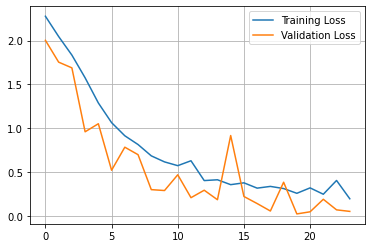

In [25]:
cnn_train_loss = history.history['loss']
cnn_val_loss = history.history['val_loss']


plt.plot(history.epoch, cnn_train_loss, label='Training Loss')
plt.plot(history.epoch, cnn_val_loss, label='Validation Loss')
plt.grid(True)
plt.legend()

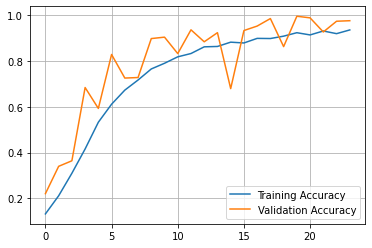

In [26]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(history.epoch, train_acc, label='Training Accuracy')
plt.plot(history.epoch, val_acc, label='Validation Accuracy')
plt.grid(True)
plt.legend()

In [27]:
cnn_model.evaluate(test_generator)

22/22 [==============================] - 43s 2s/step - loss: 0.0412 - acc: 0.9837


[0.04121276643127203, 0.98370373]